# Bigram using NN

As seen previously, we defined the negative log likelihood (NLL) loss function; so now using backprop lets train a NN to make a better bigram model. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [23]:
# define stoi 
stoi = {}
allletters = sorted(set("".join(words)))

stoi = {s:i+1 for i,s in enumerate(allletters)}
stoi['.'] = 0


In [25]:
itos = {i:s for s,i in stoi.items()}

In [32]:
# create the training dataset of bigrams
# input x (first char) -> output y (second char): bigram is ready

xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)


. e
e m
m m
m a
a .


In [33]:
# mapping from char1 to char2
xs,ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

### Intuition for training

The prized question now is: how do we feed in this data into the NN?

Feeding in integers 5,13,8 etc which are just indices of characters and calculating losses is incorrect, since a = 1 and e = 5 dont have a 'five times relation'. Its a bit like a categorical variable we are dealing with, under integral labels. 

__So we will one hot encode the input and output vectors and compute the softmax loss!__

Check data structures nb for [one hot](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) experimentation in torch. 

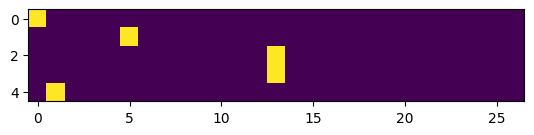

In [7]:
import torch.nn.functional as F

# specify num_classes since by looking at a part of the dataset one_hot may guess no of classes incorrectly. 
xenc = F.one_hot(xs, num_classes=27).float() # default dtype is int32, but while training float is preferred. 

plt.imshow(xenc) # to visualize

### Single neuron construction

In [8]:
W = torch.randn((27,1)) # single neuron
xenc @ W # (5,27) * (27,1) = (5,1)

# basically the scalar output of the neuron (wo bias) for 5 samples 

tensor([[-1.0351],
        [ 0.5425],
        [-0.4655],
        [-0.4655],
        [ 0.8773]])

In [53]:
g = torch.Generator().manual_seed(2166578)

W = torch.randn((27,27), generator=g, requires_grad=True) # 27 neurons
xenc @ W # matrix multiplication (5,27) * (27,27) = (5,27)

# (27,1) output of the neuron (wo bias) for each of 5 samples makes it (5,27)

tensor([[ 0.5244,  0.0414, -0.2484, -0.6292, -0.0726, -0.6728, -1.2014,  1.4231,
          1.5321,  1.0354,  0.8673, -0.7392,  1.5304, -0.2678, -0.6555,  0.9509,
          0.6796, -1.7264,  1.3797, -0.4230,  1.1706,  0.6819, -1.1738, -1.0456,
          0.4630, -0.6433,  0.0323],
        [ 1.3175,  0.3195,  1.8606, -0.5773,  1.5961, -1.7370,  0.5950, -1.7020,
         -1.7226,  0.6915,  1.3855,  0.6383,  1.4034, -1.5190,  0.0250,  0.3814,
         -0.3130,  0.5481, -2.7371, -0.2551, -1.7212, -0.8927,  0.4285, -1.6762,
          0.8715,  0.4500, -1.1311],
        [-0.3621,  0.0853,  0.6857,  0.3294,  0.3117, -1.2872, -0.4583,  0.4675,
          0.5422,  0.5708, -0.9090,  0.9767,  0.4348, -0.3717, -0.0219,  0.0388,
          0.7235, -0.0393,  1.1294, -1.0493,  1.4793, -0.9469, -0.4501, -0.7333,
          0.8578,  1.0845, -0.8685],
        [-0.3621,  0.0853,  0.6857,  0.3294,  0.3117, -1.2872, -0.4583,  0.4675,
          0.5422,  0.5708, -0.9090,  0.9767,  0.4348, -0.3717, -0.0219,  0.0388

Interpretation of `W = torch.randn((27,27))` or `W = torch.randn((27,20))` to avoid confusion:

- dim 0 = 27 = must match # of input features (depends on data) 
- dim 1 = 1 or 20 or 27 -- no of neurons (choice of user)

What does the value `(xenc @ W)[3,13]` indicate?
- The response of the 13th neuron on looking at the 3rd input!



In [54]:
print((xenc @ W)[3,13])

print(xenc[3] @ W[13])

tensor(-0.3717, grad_fn=<SelectBackward0>)
tensor(-0.3717, grad_fn=<DotBackward0>)


## Futher intuition 

1. We will restrict the NN to just a single layer of 27 neurons with no bias, for this tutorial. 

2. We will use the Softmax activation to interpret outputs of the NN. Remember we saw the importance of activation in MLP -- without which a NN is reduced to Lin Regression -- in CS229. 

3. The output above of `(xenc @ W)` is not a prob distribution (sum $\neq$ 1, not between 0 and 1 either)

4. So how do we connect `(xenc @ W)` to a prob distribution to sample next character for our bigram model?

### Le voilà: introduce softmax

__Process:__ Exponentiate the entries of `(xenc @ W)` $\rightarrow$ sum them up row-wise $\rightarrow$ divide them to create a prob map equivalent to `P` or `N2` in the simple bigram1 notebook. 

In [55]:
logits = xenc @ W 
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True) # 1 represents along rows 

# check any row and it sum
probs[1], probs[1].sum()

(tensor([0.0850, 0.0313, 0.1463, 0.0128, 0.1123, 0.0040, 0.0413, 0.0041, 0.0041,
         0.0454, 0.0910, 0.0431, 0.0926, 0.0050, 0.0233, 0.0333, 0.0166, 0.0394,
         0.0015, 0.0176, 0.0041, 0.0093, 0.0349, 0.0043, 0.0544, 0.0357, 0.0073],
        grad_fn=<SelectBackward0>),
 tensor(1., grad_fn=<SumBackward0>))

Alternatively, the [nn.Softmax()](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html) class can be directly used. 

In [56]:
m = nn.Softmax(dim = 1)
out = m(logits)
out[1]

tensor([0.0850, 0.0313, 0.1463, 0.0128, 0.1123, 0.0040, 0.0413, 0.0041, 0.0041,
        0.0454, 0.0910, 0.0431, 0.0926, 0.0050, 0.0233, 0.0333, 0.0166, 0.0394,
        0.0015, 0.0176, 0.0041, 0.0093, 0.0349, 0.0043, 0.0544, 0.0357, 0.0073],
       grad_fn=<SelectBackward0>)

Lets compute the loss on 'emma' first, which translates to:

xs, ys = (tensor([ 0,  5, 13, 13,  1]), [5, 13, 13, 1, 0])

In [57]:
#.item() changes the datatype too. 
type(xs[3].item()), xs[3].type()

(int, 'torch.LongTensor')

In [58]:
neg_log_likelihood = torch.zeros(5) # hard code 5 which is the len of xs, ys

for i in range(len(xs)):
    # i-th bigram 
    x = xs[i].item()
    y = ys[i].item()
    print(f"{i+1} bigram is '{itos[x]}{itos[y]}' (indices: {x},{y}) ")
    print('actual label = ', y)
    # prob distribution predicted for labels by NN
    print(probs[i])
    # prob that the neural net assigns to y
    prob1 = probs[i,y]
    # current prob assigned to correct label is prob1
    print(f'current prob assigned to correct label is {prob1}')
    # log likelihood
    logp = torch.log(prob1).item()
    # nll
    nll_i = - logp
    print(f'nll for {i+1}th bigram = {nll_i}')
    # append to loss list
    neg_log_likelihood[i] = nll_i
    print('----------------------')


print(f'Loss on dataset = Mean of loss = {neg_log_likelihood.mean().item()}')

1 bigram is '.e' (indices: 0,5) 
actual label =  5
tensor([0.0379, 0.0234, 0.0175, 0.0120, 0.0209, 0.0115, 0.0068, 0.0932, 0.1040,
        0.0633, 0.0535, 0.0107, 0.1038, 0.0172, 0.0117, 0.0581, 0.0443, 0.0040,
        0.0893, 0.0147, 0.0724, 0.0444, 0.0069, 0.0079, 0.0357, 0.0118, 0.0232],
       grad_fn=<SelectBackward0>)
current prob assigned to correct label is 0.011462069116532803
nll for 1th bigram = 4.468711853027344
----------------------
2 bigram is 'em' (indices: 5,13) 
actual label =  13
tensor([0.0850, 0.0313, 0.1463, 0.0128, 0.1123, 0.0040, 0.0413, 0.0041, 0.0041,
        0.0454, 0.0910, 0.0431, 0.0926, 0.0050, 0.0233, 0.0333, 0.0166, 0.0394,
        0.0015, 0.0176, 0.0041, 0.0093, 0.0349, 0.0043, 0.0544, 0.0357, 0.0073],
       grad_fn=<SelectBackward0>)
current prob assigned to correct label is 0.0049823978915810585
nll for 2th bigram = 5.301844120025635
----------------------
3 bigram is 'mm' (indices: 13,13) 
actual label =  13
tensor([0.0184, 0.0287, 0.0523, 0.0366, 0

Why is the loss so high? even for commonly expected bigrams such as `.e`

Because the weights have been initialized randomly. With iteration of GD, they will fast become more accurate. 

In [59]:
neg_log_likelihood

tensor([4.4687, 5.3018, 4.0074, 3.5504, 4.5820])

So in principle: the above process we did only for 'emma', must be replicated over all words in the dataset and corresponding mean NLL will be considered as loss on the dataset. The natural idea of dividing into batches arises. 

So now, since we have a loss function to be optimized by tuning W, the task is: __how to find the optimum `W` using backprop__?

Lets vectorize it and then flesh out forward pass, back pass, update and grad flushing. 

In [60]:
print(torch.arange(5))
probs[torch.arange(5), ys] 

tensor([0, 1, 2, 3, 4])


tensor([0.0115, 0.0050, 0.0182, 0.0287, 0.0102], grad_fn=<IndexBackward0>)

In [ ]:
# Lets vectorize it
smax = nn.Softmax(dim =1)

# forward pass

xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # 5*27 matrix
probs = smax(logits)
# loss
nll_loss = -probs[torch.arange(5), ys].log().mean() # to extract probs [bigram index, actual label] = prob assigned to correct label by NN, in vector form


tensor(4.3821, grad_fn=<NegBackward0>)

In [63]:
# backward pass

# initialize gradients 
W.grad = None 
nll_loss.backward()

In [66]:
# visualize: 
print(W.grad[0], W.grad.shape, W.shape)

tensor([ 0.0076,  0.0047,  0.0035,  0.0024,  0.0042, -0.1977,  0.0014,  0.0186,
         0.0208,  0.0127,  0.0107,  0.0021,  0.0208,  0.0034,  0.0023,  0.0116,
         0.0089,  0.0008,  0.0179,  0.0029,  0.0145,  0.0089,  0.0014,  0.0016,
         0.0071,  0.0024,  0.0046]) torch.Size([27, 27]) torch.Size([27, 27])


So each element in `W` has a gradient associated with it. We just viewed the first row of `W` above. 

- grad $>0 \implies$: W +=h will increase loss
- grad  $<0 \implies$: W +=h will decrease loss

Now lets move to the update. 

In [67]:
# update
W.data += -0.1 * W.grad

In [68]:
# forward pass

xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # 5*27 matrix
probs = smax(logits)
# loss
nll_loss = -probs[torch.arange(5), ys].log().mean() # to extract probs [bigram index, actual label] = prob assigned to correct label by NN, in vector form

nll_loss

tensor(4.3613, grad_fn=<NegBackward0>)

So we updated the weights and ran the forward pass manually again, the loss has decrease from `4.3821` to `4.3613`. 

### Lets create a loop out of this:
(on the entire dataset)

In [69]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [ ]:
# gradient descent
for k in range(100):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # with a regulariziation loss
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad # a experiment with the lr, but a large value is OK here. 

2.481499195098877
2.4814915657043457
2.4814834594726562
2.481475591659546
2.4814682006835938
2.4814603328704834
2.481452465057373
2.4814453125
2.4814376831054688
2.4814302921295166
2.4814231395721436
2.4814157485961914
2.4814083576202393
2.4814016819000244
2.4813942909240723
2.4813878536224365
2.4813807010650635
2.4813737869262695
2.481367349624634
2.481360673904419
2.481353759765625
2.4813473224639893
2.4813406467437744
2.4813342094421387
2.481327772140503
2.481321334838867
2.4813153743743896
2.481309175491333
2.4813029766082764
2.4812965393066406
2.481290578842163
2.4812848567962646
2.481278657913208
2.4812726974487305
2.481267213821411
2.4812612533569336
2.481255531311035
2.4812498092651367
2.4812443256378174
2.481238603591919
2.4812331199645996
2.4812276363372803
2.481222152709961
2.4812166690826416
2.4812116622924805
2.481206178665161
2.481201171875
2.4811959266662598
2.4811906814575195
2.4811854362487793
2.481180191040039
2.481175661087036
2.481170177459717
2.481165647506714
2.48

I ran the above cell 4 times (400 iterations) and the loss seems to have converged to `2.48`. 

<span style="color:#FF0000; font-family: 'Bebas Neue'; font-size: 01em;">IMPORTANT:</span>
Even if we run the original 'explicit' approach to predict the next char of a bigram, we will get the _same_ loss! __This is because the explicit approach calculates direct porbabilities while NN arrives at the same place iteratively!!__


In [75]:
# sampling from the network: 

# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cfay.
a.


So if the manual key for RNG is same for explicit and NN model, they output words are also exactly the same -- as is demonstrated by Andrej's code. 

Points be NN and explicit method:
- NNs are fundamentally more scalable, we can't maintain a prob table when say the context is 10 previous characters or smth.
- The _log of_ bigram matrix `N2` in explicit approach is the same as `W` in NN approach at the end of iterations(!)

### Smoothing vs regularization:

- In explicit approach we used smoothing but have non-zero probability for each bigram.
- But in the NN approach, regularization using `0.01*(W**2).mean()` in loss prevents overfitting, by pushing the weights to `0` simultaneously, penalizing very high weights. 
- The reg. constant ($\lambda$) covers up for the smoothening constant. $\lambda \uparrow \implies$ incentive towards uniform distribution of $W = 0$ ~ high smoothening constant $c$

## Way forward:
- Use multiple chars for context while prediction.
- Work with more complex NN architectures. 

Despite both these modifications, the NN will output logits and we will compute softmax probabilities and use NLL loss as metric to minimize. This NN will complexify all the way into a transformer. 